In [80]:
import numpy as np
import pickle
import os
import pyimfit
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import angular_separation
import corner
import matplotlib.pyplot as plt
import pandas as pd
from photutils import profiles
from tqdm import tqdm
import logging
import warnings
from matplotlib.backends.backend_pdf import PdfPages
from astropy.visualization import simple_norm
warnings.filterwarnings('ignore')
from photutils.isophote import EllipseSample, Isophote
from photutils.isophote.sample import CentralEllipseSample
from photutils.isophote.fitter import CentralEllipseFitter
from photutils.isophote import build_ellipse_model,Ellipse, EllipseGeometry, IsophoteList
from matplotlib.ticker import FormatStrFormatter
import glob
import matplotlib.gridspec as gridspec
from photutils.aperture import EllipticalAperture
from photutils.detection import find_peaks
import astropy.units as u
from astropy.cosmology import WMAP9 as cosmo
import seaborn as sns

medium_font_size = 14 
plt.rcParams['font.size'] = medium_font_size
plt.rcParams['axes.labelsize'] = medium_font_size
plt.rcParams['axes.titlesize'] = medium_font_size
plt.rcParams['xtick.labelsize'] = medium_font_size
plt.rcParams['ytick.labelsize'] = medium_font_size
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'monospace'
# fl = os.listdir("../cutouts/data")
# agns = sorted([f[:-5] for f in fl if f[0]=="J"])

# make galaxy models
I_tot is the integrated intensity. Feeding position at 50,70 gives model image at 49,69

In [127]:
def find_highest_indices(arr):
    """returns a tuple of ys, xs - indices of pixels with highest counts"""
    flattened_arr = np.array(arr).flatten()
    max_indices = np.unravel_index(np.argsort(flattened_arr)[-2:], arr.shape)
    return max_indices

def crop_image(imageAGN, size=40):
    ysO,xsO = find_highest_indices(imageAGN)
    # find the center of AGNs
    ycO = int(np.sum(ysO)/2)
    xcO = int(np.sum(xsO)/2)
    # crop
    px=int(size/2)
    imageAGNcrop = imageAGN[ycO-px:ycO+px,xcO-px:xcO+px]
    # find agn centers in cropped image
    ys,xs = find_highest_indices(imageAGNcrop)
    return imageAGNcrop, ys, xs

def makeModelDict(PA_ss, ell_ss, n_ss, I_ss, r_ss, Itot,
                 PA_lim, ell_lim, I_lim,  Iss_lim, rss_lim, Itot_lim,
                 sigma, sigma_lim, Isky, Isky_lim,
                 h1,h2,h_lim,alpha,alpha_lim):
    """Return Sersic, PSF, and Gaussian model parameter dictionary"""
    # Sersic
    """sersic = {'PA': [PA_ss, PA_lim[0],PA_lim[1]], 'ell_bulge': [ell_ss, ell_lim[0],ell_lim[1]], 'n': [n_ss, 'fixed'],
    'I_e': [I_ss, Iss_lim[0],Iss_lim[1]], 'r_e': [r_ss, rss_lim[0],rss_lim[1]]}"""
    sersic = {'PA': [PA_ss, PA_lim[0],PA_lim[1]], 'ell_bulge': [ell_ss, ell_lim[0],ell_lim[1]], 'n': [n_ss, 0, 10],
    'I_e': [I_ss, Iss_lim[0],Iss_lim[1]], 'r_e': [r_ss, rss_lim[0],rss_lim[1]]}
    sersic_dict = {'name': "Sersic", 'label': "bulge", 'parameters': sersic}
    # PSF
    psf = {'I_tot' : [Itot, Itot_lim[0], Itot_lim[1]]}
    psf_dict = {'name': "PointSource", 'label': "psf", 'parameters': psf}
    # Rot psf
    psfRot = {'I_tot' : [Itot, Itot_lim[0], Itot_lim[1]], 'PA':[PA_ss, PA_lim[0],PA_lim[1]] }
    psfRot_dict = {'name': "PointSourceRot", 'label': "psf", 'parameters': psfRot}
    # Gaussians
    gaussian = {'PA':[PA_ss, PA_lim[0],PA_lim[1]], 'ell':[ell_ss, ell_lim[0],ell_lim[1]], 
                'I_0':[I_ss, Iss_lim[0],Iss_lim[1]], 'sigma':[sigma, sigma_lim[0], sigma_lim[1]]}
    gaussian_dict = {'name': "Gaussian", 'label': "gaussian", 'parameters': gaussian}
    # Flat sky
    flatsky = {'I_sky': [Isky, Isky_lim[0], Isky_lim[1]]}
    flatsky_dict = {'name': "FlatSky", 'label': "flat_sky", 'parameters':flatsky}
    # flat bar
    flatbar = {'PA':[PA_ss, PA_lim[0],PA_lim[1]], 'ell':[ell_ss, ell_lim[0],ell_lim[1]],
               'deltaPA_max':[PA_ss, PA_lim[0],PA_lim[1]], 'I_0':[I_ss, Iss_lim[0],Iss_lim[1]],
               'h1':[h1, h_lim[0],h_lim[1]], 'h2':[h2, h_lim[0],h_lim[1]], 
               'r_break':[r_ss, rss_lim[0],rss_lim[1]], 'alpha':[alpha,alpha_lim[0],alpha_lim[1]]}
    flatbar_dict = {'name': "FlatBar", 'label': "flat_bar", 'parameters':flatbar}
    # Exponential
    exponential = {'PA': [PA_ss, PA_lim[0],PA_lim[1]], 'ell': [ell_ss, ell_lim[0],ell_lim[1]], 
                   'I_0': [I_ss, Iss_lim[0],Iss_lim[1]], 'h': [h1, h_lim[0],h_lim[1]]}
    exp_dict = {'name': "Exponential", 'label': "disk", 'parameters':exponential}
    return sersic_dict, psf_dict, gaussian_dict, flatsky_dict, flatbar_dict,exp_dict
      
def galaxy_funcdict(X0, Y0, X1, Y1, Xss0, Yss0, Xss1, Yss1, 
                    Xlim, Ylim, Xsslim, Ysslim,
                    PA_ss, ell_ss, n_ss, I_ss, r_ss, Itot,
                    PA_lim, ell_lim, I_lim,  Iss_lim, rss_lim, Itot_lim,
                    sigma, sigma_lim, midf, Isky, Isky_lim,
                    h1,h2,h_lim,alpha,alpha_lim):
    """Returns a function set dictionary with keys as model name, 
       values as model function set"""
    sersic_dict, psf_dict, gaussian_dict, flatsky_dict, flatbar_dict,exp_dict = makeModelDict(PA_ss, ell_ss, n_ss, I_ss, r_ss, Itot,
                                                                                     PA_lim, ell_lim, I_lim,  Iss_lim, rss_lim, Itot_lim,
                                                                                     sigma, sigma_lim, Isky, Isky_lim,
                                                                                     h1,h2,h_lim,alpha,alpha_lim)
    #========function dictionary
    # psf
    funcset_dict_psf0 = {'X0': [X0,Xlim[0],Xlim[1]], 'Y0': [Y0, Ylim[0],Ylim[1]], 
                    'function_list': [psf_dict]}
    funcset_dict_psf1 = {'X0': [X1,Xlim[0],Xlim[1]], 'Y0': [Y1, Ylim[0],Ylim[1]], 
                    'function_list': [psf_dict]}
    # separate sersic
    funcset_dict_sersic0 = {'X0': [Xss0,Xsslim[0],Xsslim[1]], 'Y0': [Yss0,Ysslim[0],Ysslim[1]], 
                   'function_list': [sersic_dict]}
    funcset_dict_sersic1 = {'X0': [Xss1,Xsslim[0],Xsslim[1]], 'Y0': [Yss1,Ysslim[0],Ysslim[1]], 
                   'function_list': [sersic_dict]}
    # overall sersic
    funcset_dict_sersicT = {'X0': [midf,Xsslim[0],Xsslim[1]], 'Y0': [midf,Ysslim[0],Ysslim[1]], 
                   'function_list': [sersic_dict]}
    # same center psf+sersic
    funcset_dict_psfser0 = {'X0': [X0,Xlim[0],Xlim[1]], 'Y0': [Y0, Ylim[0],Ylim[1]], 
                    'function_list': [psf_dict,sersic_dict]}
    funcset_dict_psfser1 = {'X0': [X1,Xlim[0],Xlim[1]], 'Y0': [Y1, Ylim[0],Ylim[1]], 
                    'function_list': [psf_dict,sersic_dict]}
    # flat bar
    funcset_dict_flatbar = {'X0': [midf,Xlim[0],Xlim[1]], 'Y0': [midf, Ylim[0],Ylim[1]], 
                    'function_list': [flatbar_dict]}
    funcset_dict_psfserbar = {'X0': [X0,Xlim[0],Xlim[1]], 'Y0': [Y0, Ylim[0],Ylim[1]], 
                    'function_list': [psf_dict,sersic_dict,flatbar_dict]}
    funcset_dict_psfbar0 = {'X0': [X0,Xlim[0],Xlim[1]], 'Y0': [Y0, Ylim[0],Ylim[1]], 
                    'function_list': [flatbar_dict,psf_dict]}
    funcset_dict_psfbar1 = {'X0': [X1,Xlim[0],Xlim[1]], 'Y0': [Y1, Ylim[0],Ylim[1]], 
                    'function_list': [flatbar_dict,psf_dict]}
    funcset_dict_sersicbar = {'X0': [X1,Xlim[0],Xlim[1]], 'Y0': [Y1, Ylim[0],Ylim[1]], 
                    'function_list': [flatbar_dict,sersic_dict]}
    # exponential
    funcset_dict_exp = {'X0': [midf,Xlim[0],Xlim[1]], 'Y0': [midf, Ylim[0],Ylim[1]], 
                    'function_list': [exp_dict]}
    funcset_dict_psfexp = {'X0': [midf,Xlim[0],Xlim[1]], 'Y0': [midf, Ylim[0],Ylim[1]], 
                    'function_list': [psf_dict,exp_dict]}
    funcset_dict_psfserexp= {'X0': [midf,Xlim[0],Xlim[1]], 'Y0': [midf, Ylim[0],Ylim[1]], 
                    'function_list': [psf_dict,sersic_dict,exp_dict]}
    funcset_dict_serexp= {'X0': [midf,Xlim[0],Xlim[1]], 'Y0': [midf, Ylim[0],Ylim[1]], 
                    'function_list': [sersic_dict,exp_dict]}
    
    #========model dict
    funcset = {
        # 2 gals/cores
        "2sersic":[funcset_dict_sersic0,funcset_dict_sersic1],
        "1psf0,2sersic":[funcset_dict_psf0,funcset_dict_sersic0,funcset_dict_sersic1],
        "1psf1,2sersic":[funcset_dict_psf1,funcset_dict_sersic0,funcset_dict_sersic1],
        "1psf+sersic,1psf": [funcset_dict_psfser0,funcset_dict_psf1],
        "1psf+sersic,sersic": [funcset_dict_sersic1,funcset_dict_psfser0],
        "1psf+sersic,sersic,sersic": [funcset_dict_sersic1,funcset_dict_psfser0,funcset_dict_sersicT],
        "sersic,1psf+sersic": [funcset_dict_sersic0,funcset_dict_psfser1],
        "2psf": [funcset_dict_psf0, funcset_dict_psf1],
        "2psf+sersic,sameCenter": [funcset_dict_psfser0,funcset_dict_psfser1],
        "2psf+sersic,diffCenter":[funcset_dict_psf0, funcset_dict_psf1,funcset_dict_sersic0,funcset_dict_sersic1],
        "2psf,overall Sersic": [funcset_dict_psf0, funcset_dict_psf1,funcset_dict_sersicT],
        
        "1psf+sersic,bar":[funcset_dict_psfser1, funcset_dict_flatbar],
        "1psf,sersic,bar":[funcset_dict_psf1,funcset_dict_sersic0,funcset_dict_flatbar],
        "1psf+sersic+bar":[funcset_dict_psfserbar],
        "1psf,bar":[funcset_dict_psf0,funcset_dict_flatbar],
        "1psf+bar":[funcset_dict_psfbar0],
        "1sersic,bar":[funcset_dict_sersic0,funcset_dict_flatbar],
        "1sersic+bar":[funcset_dict_sersicbar],
        
        "1psf+bar,sersic":[funcset_dict_psfbar0, funcset_dict_sersic1],
        "1psf+bar,sersic0":[funcset_dict_psfbar0, funcset_dict_sersic0],
        "1psf+bar,1psf":[funcset_dict_psfbar0,funcset_dict_psf1],
        "1sersic+bar,1psf":[funcset_dict_psf0, funcset_dict_sersicbar],
        "1sersic+bar,sersic":[funcset_dict_sersicbar,funcset_dict_sersic0],
        "1psf+sersic,1psf+bar": [funcset_dict_psfbar0, funcset_dict_psfser0],
        "2psf+bar,sameCenter":[funcset_dict_psfbar0,funcset_dict_psfbar1],
       
        "1psf": [funcset_dict_psf0],
        "1psf+sersic": [funcset_dict_psfser0],
        "1psf+sersic,exp": [funcset_dict_psfser0,funcset_dict_exp],
        "1psf+sersic+exp": [funcset_dict_psfserexp],
        "psf,sersic+exp": [funcset_dict_serexp,funcset_dict_psf0],
        "sersic+exp":[funcset_dict_serexp],
        "psf+exp":[funcset_dict_psfexp]
    }
    return funcset

def galaxy_model(X0, Y0, X1, Y1, Xss0, Yss0, Xss1, Yss1, Xlim, Ylim, Xsslim, Ysslim,
                PA_ss, ell_ss, n_ss, I_ss, r_ss, Itot,
                PA_lim, ell_lim, I_lim,  Iss_lim, rss_lim, Itot_lim,
                sigma, sigma_lim,midf, Isky, Isky_lim,h1,h2,h_lim,alpha,alpha_lim):
    """return a dictionary of galaxy model with keys as model name"""
    funcset = galaxy_funcdict(X0, Y0, X1, Y1, Xss0, Yss0, Xss1, Yss1, Xlim, Ylim, Xsslim, Ysslim,
                    PA_ss, ell_ss, n_ss, I_ss, r_ss, Itot,
                    PA_lim, ell_lim, I_lim,  Iss_lim, rss_lim, Itot_lim,
                    sigma, sigma_lim,midf, Isky, Isky_lim,h1,h2,h_lim,alpha,alpha_lim);
    models = {}
    for model in funcset:
        models[model]= pyimfit.ModelDescription.dict_to_ModelDescription({'function_sets':funcset[model]});
    return models

def dofit_no_oversp(modelName, dataImage, psf, readnoise=0.22, expT=1, skylevel = 654.63, ncom=4, solver="NM",effgain=1):
    """do fit with not oversampled psf
       """
    fitter = pyimfit.Imfit(models_n1[modelName],psf=psf)
    fitter.loadData(dataImage,exp_time=expT, 
                    read_noise=readnoise, original_sky=skylevel,n_combined=ncom,gain=effgain)
    fitter.doFit(solver)
    fitConfig = fitter.getModelDescription()
    fitModelImage = fitter.getModelImage()
    fitResult = fitter.getFitResult()
    param_names = fitter.numberedParameterNames
    return fitConfig, fitModelImage, fitResult, param_names,fitter

def fit_multi(models,epsf):
    """fit all models in models
       return lists of model config, model images, fit results, and parameter names"""
    models = list(models.keys())
    configs = []
    modelIms = []
    fitResults = []
    pnames= []

    logging.basicConfig(filename='error.log', level=logging.ERROR, format='%(asctime)s - %(levelname)s - %(message)s')
    # fit all models
    for modelName in tqdm(models, desc="Fitting models"):
        try:
            config, modelIm, fitRes, pname = dofit_no_oversp(modelName, dataImage=imageAGNcrop, psf=epsf, solver="LM")
            configs.append(config)
            modelIms.append(modelIm)
            fitResults.append(fitRes)
            pnames.append(pname)
        except Exception as e:
            error_message = f"An error occurred for {modelName}: {e}"
            logging.error(error_message)
            print(error_message) 
            continue  
    return configs, modelIms, fitResults, pnames

def save_data(models,configs,modelIms,fitResults,pnames,filename):
    savedata = {}
    savedata['modelNames'] = models
    savedata['configs'] = configs
    savedata['modelImage'] = modelIms
    savedata['fitResults'] = fitResults
    savedata['paramNames'] = pnames
    pickle.dump(savedata,open(filename,"wb"))
    
def plot_fit(filename, figtitle):
    with open(filename, 'rb') as file:
        d = pickle.load(file)
    nrows=6
    ncols=3
    fig,ax = plt.subplots(nrows,ncols,figsize=(9,18))
    ax = ax.ravel()
    modelNum = len(d['fitResults'])
    fitStats = [d['fitResults'][i].fitStat for i in range(modelNum)]

    for i, j in zip(np.argsort(fitStats),np.arange(modelNum)):
        resi = imageAGNcrop-d['modelImage'][i]
        im = ax[j].imshow(resi,cmap="coolwarm")
        title = d['modelNames'][i]
        title = '\n'.join(title.split(',', 1)) if len(title) > 15 else title
        ax[j].set_title(title, fontsize=10)
        fig.colorbar(im, ax=ax[j], shrink=0.7)
        rmsNoise = np.sqrt(np.sum(resi**2)/imageAGNcrop.shape[0]**2)
        iRatio = np.sum(resi)/np.sum(imageAGNcrop)*100
        ax[j].text(0.05, 0.25, f"$\chi^2$:{fitStats[i]:.2f}", transform=ax[j].transAxes, fontsize=10, color='k')
        ax[j].text(0.05, 0.15, f"noise RMS:{rmsNoise:.2f}", transform=ax[j].transAxes, fontsize=10, color='k')
        ax[j].text(0.05, 0.05, f"% I_res: {iRatio:.2f}", transform=ax[j].transAxes, fontsize=10, color='k')
    # turn off empty axes
    empty_axes = nrows*ncols-modelNum
    [ax[-i].axis('off') for i in np.arange(1,empty_axes+1)]
    fig.suptitle(figtitle)
    fig.tight_layout();
       
def fit_df(filename):
    with open(filename, 'rb') as file:
        d = pickle.load(file)
    modelNum = len(d['fitResults'])
    pd.set_option('display.max_colwidth',1)
    best5i = np.argsort([d['fitResults'][i].fitStat for i in range(modelNum)])[:5]
    dfs = [pd.DataFrame([d['paramNames'][n],d['fitResults'][n].params],index=['',d['modelNames'][n]]).T for n in best5i]
    dfs = pd.concat(dfs, axis=1).fillna('')
    newcol = [' \n '.join(col.split(',', 1)) if len(col) > 15 else col for col in dfs.columns]
    dfs.columns = newcol
    return dfs

def ang_sep():
    w = WCS(imageFile)
    ra1,dec1 = w.pixel_to_world_values(dic['X0_2'],dic['Y0_2'])
    ra2,dec2 = w.pixel_to_world_values(dic['X0_2']+dic['r_e_4'],dic['Y0_2']+dic['r_e_4'])
    angular_separation(ra1,dec1,ra2,dec2)
    pass

def find_sky(imageAGNcrop, plothist=False):
    bgr = plt.hist(imageAGNcrop.flatten(),bins=np.arange(np.min(imageAGNcrop),20))
    plt.close()
    max_ind = np.where(bgr[0]==np.max(bgr[0]))[0][0]
    sky = (bgr[1][max_ind]+bgr[1][max_ind+1])/2
    if plothist:
        fig,ax = plt.subplots(1,2,figsize=(10,4))
        ax[0].hist(imageAGNcrop.flatten(),bins=np.arange(np.min(imageAGNcrop),np.max(imageAGNcrop)))
        ax[1].hist(imageAGNcrop.flatten(),bins=np.arange(np.min(imageAGNcrop),20))
        [ax[i].set_title(['Whole intensity range',f'sky level: {float(sky):.4f}'][i]) for i in range(2)]
        [ax[i].set_xlabel('intensity') for i in range(2)]
        ax[0].set_ylabel('number of agns') 
    return sky


In [167]:
def profile_1D(semiA,image,PA=180,ell=0.5):
    """make 1D elliptical profiles"""
    # create guess ellipse
    pos0 = image.shape[0]//2
    geometry = EllipseGeometry(x0=pos0, y0=pos0, sma=semiA, eps=ell,
                               pa=PA * np.pi / 180.0)
    # load image and geometry
    ellipse = Ellipse(image, geometry)
    # do isophote fit
    isolist = ellipse.fit_image()
    return isolist

def plot_isophotes(ax,isolist,num_aper=10):
    """plot aperatures on image"""
    for sma in np.linspace(isolist.sma[0],isolist.sma[-1],num_aper):
        iso = isolist.get_closest(sma)
        x, y, = iso.sampled_coordinates()
        ax.plot(x, y, color='white',linewidth="0.5")
        
def make_model_components(config,imshape):
    """make model component images from best fit config"""
    comp_names = config.functionLabelList()
    comp_ims=[]
    comp_pos = []
    for i in range(len(config.getModelAsDict()['function_sets'])):
        posX = config.getModelAsDict()['function_sets'][i]['X0']
        posY = config.getModelAsDict()['function_sets'][i]['Y0']
        functions = config.getModelAsDict()['function_sets'][i]['function_list']
        for j in range(len(functions)):
            funcset_dict = {'X0': posX, 'Y0': posY, 'function_list': [functions[j]]}
            model_dict = {'function_sets': [funcset_dict]}
            model = pyimfit.ModelDescription.dict_to_ModelDescription(model_dict)
            imfit_fitter = pyimfit.Imfit(model,epsf)
            comp_ims.append(imfit_fitter.getModelImage(shape=(imshape,imshape)))
            comp_pos.append([posX[0],posY[0]])
    return comp_ims, comp_pos, comp_names

def plot_model_components(comp_ims,comp_names,comp_pos,isolist_comps, colormap="ch:s=-.3,r=.6", plotIso=False,shrink_ratio=0.5):
    """plot 2D model components and check residual with model image"""
    clmap = sns.color_palette(colormap, as_cmap=True)
    ncom = len(comp_names)
    fig,ax = plt.subplots(nrows=1,ncols=ncom+1, figsize=(ncom*4,3))
    im = [ax[i].imshow(comp_ims[i],norm='symlog',cmap=clmap) for i in range(ncom)]
    [ax[i].text(0.05, 0.05, f"(x,y)=({comp_pos[i][0]:.1f},{comp_pos[i][1]:.1f})", transform=ax[i].transAxes, fontsize=8, color='k') for i in range(ncom-1)]
    [ax[i].set_title(comp_names[i]) for i in range(ncom)]
    im.append(ax[-1].imshow(np.sum(comp_ims[:-1],axis=0)-comp_ims[-1],norm='symlog',cmap=clmap))
    ax[-1].set_title("model-comps")
    [fig.colorbar(im[i], ax=ax[i], shrink=shrink_ratio).ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f')) for i in range(len(ax))]
    if plotIso:
        for i in range(len(isolist_comps)):
             plot_isophotes(ax[i],isolist_comps[i],num_aper=5)
    fig.tight_layout();


def fit_stat_1d(iso_data,iso_model,nparams,cut=0.8):
    """calculate 1d chi squared, cut to 80% of data"""
    cut_index = int(np.round(len(iso_data.sma)*cut))
    sma_cut = iso_data.sma[cut_index]
    diff = iso_data.intens[1:cut_index]-iso_model.intens[1:cut_index]
    chi_square1d_reduced = np.sum((diff/iso_data.rms[1:cut_index])**2)/(cut_index-nparams)
    diff_full = iso_data.intens[1:]-iso_model.intens[1:]
    chi_square1d_full_reduced = np.sum((diff_full/iso_data.rms[1:])**2)/(len(iso_data)-1-nparams)
    return chi_square1d_reduced,sma_cut,chi_square1d_full_reduced


def plot_1isophote(ax,sma,isolist):
    """plot aperatures on image"""
    iso = isolist.get_closest(sma)
    x, y, = iso.sampled_coordinates()
    ax.plot(x, y, color='white',linewidth="0.3")


def pix_to_arcsec(imageFile,framelim):
    w = WCS(imageFile)
    # convert pixel to degree
    ra1,dec1 = w.pixel_to_world_values(0,0)
    ra2,dec2 = w.pixel_to_world_values(framelim,framelim)
    framelim_deg = angular_separation(ra1*u.degree,dec1*u.degree,ra2*u.degree,dec2*u.degree)
    # find pixel-arsec scale
    framelim_arcsec = framelim_deg.to('arcsec')
    arcsec_per_pix = framelim_arcsec/framelim
    return arcsec_per_pix, [ra1,dec1,ra2,dec2]

def surface_brightness(intensity, area, magZPT):
    return -2.5*np.log10(intensity/area)+ magZPT


def radial_plot_params(imageFile, framelim, isolist_data,isolist_comps,hdu_exp,z=0.2):
    # convert pixel to arcsec and kpc
    arcsec_per_pix, skycoords = pix_to_arcsec(imageFile,framelim)
    sma_arcsec = isolist_data.sma*arcsec_per_pix
    sma_kpc = (cosmo.angular_diameter_distance(z)*sma_arcsec.to('rad').value).to('kpc')
    # calculate isophote areas and find surface brightness
    areas = (np.sqrt((1-isolist_data.eps**2)*sma_arcsec**2)*np.pi*sma_arcsec).value
    magZPT = hdu_exp.header['MAGZP']
    mu_data = [surface_brightness(i,areas,magZPT) for i in [isolist_data.intens,isolist_data.intens-isolist_data.int_err,isolist_data.intens+isolist_data.int_err]]
    mu_models = [[surface_brightness(i,areas,magZPT) for i in [isolist_comps[j].intens,isolist_comps[j].intens-isolist_comps[j].int_err,isolist_comps[j].intens+isolist_comps[j].int_err]] for j in range(len(isolist_comps))]
    return sma_arcsec, sma_kpc, mu_data, mu_models, skycoords
    

def plot_everything(on,image,m,modelname,comp_names,fsr,sma_arcsec,sma_kpc,mu_data,mu_models,skycoords,colormap):
    colors = sns.color_palette(colormap, len(comp_names)+1)[1:]
    cmapp = sns.color_palette(colormap, as_cmap=True).reversed()
    # Create grid and add subplots
    fig = plt.figure(figsize=(14, 4),layout='tight')
    gs = gridspec.GridSpec(2, 4, height_ratios=[3, 1], width_ratios=[1.25,1.25,1,1.5],hspace=0.05,wspace=0.05)
    ax1 = fig.add_subplot(gs[:, 0],xlabel='RA (deg)',ylabel='DEC (deg)') 
    ax2 = fig.add_subplot(gs[:, 1],xticks=[],yticks=[])
    ax3 = fig.add_subplot(gs[:, 2],xticks=[],yticks=[])
    ax4a = fig.add_subplot(gs[0, 3]) 
    ax4b = fig.add_subplot(gs[1, 3])   
    # formatting ticks
    xticks = np.linspace(skycoords[0],skycoords[2],4)
    yticks = np.linspace(skycoords[1],skycoords[3],4)
    ax1.set_xticks(np.linspace(0,image.shape[0],4))
    ax1.set_yticks(np.linspace(0,image.shape[0],4))
    ax1.set_xticklabels([f'{x:.3f}' for x in xticks])
    ax1.set_yticklabels([f'{y:.3f}' for y in yticks],rotation=90)
    ax1.tick_params(direction='in')
    # plot 2d and colorbars
    ax = [ax1,ax2,ax3,ax4a,ax4b]
    im = [ax[i].imshow([image, m, image-m][i], norm='symlog',cmap=cmapp) for i in range(3)]
    [fig.colorbar(im[i],ax=ax[i],orientation='horizontal',location='bottom',pad=0.05) for i in range(2,3)]
    fig.colorbar(im[0],ax=[ax[0],ax[1]],orientation='vertical',location='right',shrink=0.5)
    [ax[i].set_title([on,f"Model:\n{modelname}",f'Residual,$\chi^2_r$={fsr:.2f}'][i]) for i in range(3)]
    # radial plot data
    ax[3].plot(sma_arcsec[1:],mu_data[0][1:],label="data",c='cornflowerblue')
    ax[3].fill_between(sma_arcsec[1:].value,mu_data[1][1:],mu_data[2][1:],color='cornflowerblue',alpha=0.5)
    # radial plot model
    ax[3].plot(sma_arcsec[1:],mu_models[-1][0][1:],label="model",c=colors[-1],linestyle="dashdot")
    ax[3].fill_between(sma_arcsec[1:].value, mu_models[-1][1][1:],mu_models[-1][2][1:],color=colors[-1],alpha=0.5)
    # radial plot components
    [ax[3].plot(sma_arcsec[1:],mu_models[i][0][1:],label=comp_names[i],linestyle="dashdot",c=colors[i]) for i in range(len(comp_names)-1)]
    [ax[3].fill_between(sma_arcsec[1:].value,mu_models[i][1][1:],mu_models[i][2][1:],color=colors[i],alpha=0.5) for i in range(len(comp_names)-1)]
    ax[4].plot(sma_kpc[1:],mu_data[0][1:]-mu_models[-1][0][1:],c=colors[-2],linestyle="dashdot")
    ax[4].fill_between(sma_kpc[1:].value,mu_data[1][1:]-mu_models[-1][1][1:],mu_data[2][1:]-mu_models[-1][2][1:],color=colors[-2],alpha=0.5)
    ax[4].axhline(y=0,linestyle='--',c='cornflowerblue',lw=1)
    # format ticks
    ax[3].invert_yaxis()
    ax[3].set_xlabel("R[arcsec]")
    ax[3].set_ylabel("$\mu$ [mag arcsec$^{-2}$]")
    ax[3].xaxis.set_label_position('top') 
    ax[3].xaxis.set_ticks_position('top') 
    ax[3].legend(fontsize=10,loc='upper right')
    
    ax[4].set_xlabel("R[kpc]")
    ax[4].set_ylabel("$\Delta \mu$") 
    ax[4].set_ylim((-0.5,0.5))
    [ax.yaxis.set_label_position('right') for ax in [ax4a,ax4b]]
    [ax.yaxis.set_ticks_position('right') for ax in [ax4a,ax4b]];


def make_model_isophotes(isolist_data, comp_ims, comp_names, midf):
    isolist_comps=[]
    circ = [comp_names[i]=='psf' for i in range(len(comp_names))]
    for i in range(len(comp_ims)):
        isolist_ = []
        for iso in isolist_data[1:]:
            g = iso.sample.geometry
            ell = 0 if circ[i] else g.eps
            gn = EllipseGeometry(g.x0,g.y0, g.sma, ell, g.pa)
            sample = EllipseSample(comp_ims[i],g.sma,geometry=gn)
            sample.update()
            iso_ = Isophote(sample,0,True,0)
            isolist_.append(iso_)
        isolist = IsophoteList(isolist_)
        g = EllipseGeometry(midf,midf, 0.0, 0., 0.)
        sample = CentralEllipseSample(comp_ims[i], 0., geometry=g)
        fitter = CentralEllipseFitter(sample)
        center = fitter.fit()
        isolist.append(center)
        isolist.sort()
        isolist_comps.append(isolist)
    return isolist_comps

def make_data_isophotes(data,sma,midf):
    isolist_data = profile_1D(semiA=sma,image=data)
    # discard first isophote and make new
    isolist_data = isolist_data[1:]
    g = EllipseGeometry(midf,midf, 0.0, 0., 0.)
    sample = CentralEllipseSample(data, 0., geometry=g)
    fitter = CentralEllipseFitter(sample)
    center = fitter.fit()
    isolist_data.append(center)
    isolist_data.sort()
    return isolist_data

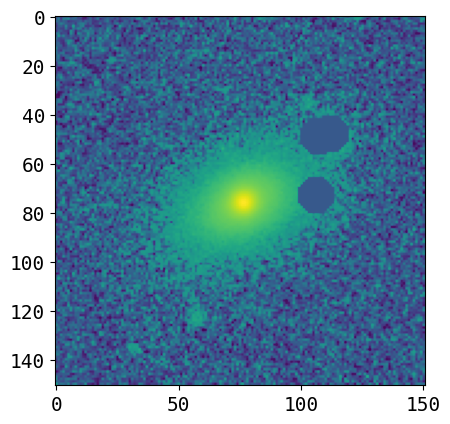

In [154]:
def make_peak_tbl(image,intens,agn_mask_size=35):
    """mask out agn and find peaks"""
    s = image.shape[0]
    midf = int(s//2)
    # mask out central agn
    peak_mask = np.zeros((s,s))
    peak_mask[midf-agn_mask_size:midf+agn_mask_size,midf-agn_mask_size:midf+agn_mask_size] = 1
    # convert to boolean
    peak_mask = peak_mask==1
    # detect peaks
    peak_tbl = find_peaks(image,threshold=intens,mask=peak_mask)
    return peak_tbl


def make_mask(image,pos,aper_radius,pa=180):
    """make a mask provided position and aperture radius"""
    aper0 = EllipticalAperture(pos,aper_radius,aper_radius,pa)
    aper_mask0 = aper0.to_mask()
    mask0 = aper_mask0.to_image(image.shape)
    return mask0

def mask_image(image,rad,intens,agn_mask_size):
    """create mask and masked images"""
    peak_tbl = make_peak_tbl(image,intens,agn_mask_size)
    mask=[]
    # make masks
    for i in range(len(peak_tbl)):
        mask.append(make_mask(image,pos = [peak_tbl[i]['x_peak'],peak_tbl[i]['y_peak']],aper_radius=rad))
    # sum all masks
    mask = np.sum(mask,axis=0)
    # make masked image
    masked_im = np.where(mask==0,image,0)
    return masked_im

plt.imshow(mask_image(image=imageAGN,rad=7,intens=10,agn_mask_size=25), norm='symlog')
imageAGN_masked = mask_image(image=imageAGN,rad=7,intens=10,agn_mask_size=25)

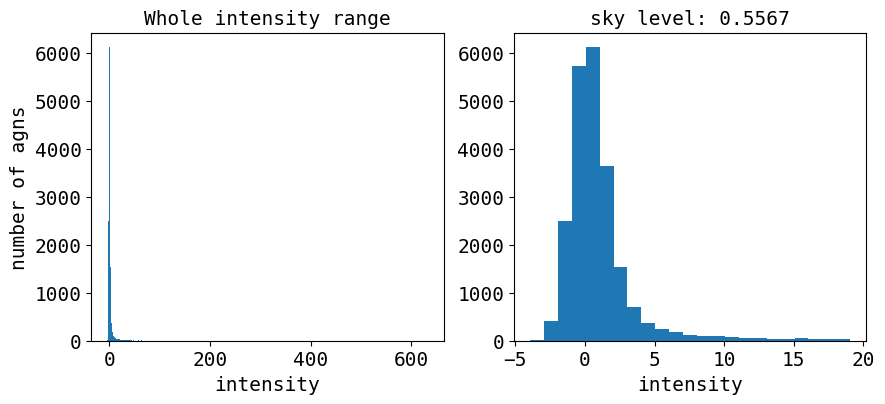

In [130]:
on = "J0400-0652"
imageFile = glob.glob(os.path.expanduser("~/agn-result/box/final_cut/"+on+"*"))[-1]
imageAGN = fits.getdata(os.path.expanduser(imageFile))
with open(os.path.expanduser("~/research-data/psf-results/psf_pkls/psf_"+on+".pkl"),"rb") as f:
    d = pickle.load(f)
epsf = d['psf'].data

# cropping image and find centers
#imageAGN, ys, xs = crop_image(imageAGN,size=10)
ys,xs = find_highest_indices(imageAGN)
Imax = imageAGN.max()
itot=1500
framelim = imageAGN.shape[0]
midF=framelim//2

# for testing 1 model at a time
def make1model(xpos,ypos,function_dict,psf,dataImage):
    func_set_dict = {'X0': xpos, 'Y0': ypos, 
                    'function_list': [function_dict]}
    funcset = [func_set_dict]
    model= pyimfit.ModelDescription.dict_to_ModelDescription({'function_sets':funcset})
    fitter = pyimfit.Imfit(model,psf=psf)
    return fitter


sersic_dict, psf_dict, gaussian_dict, flatsky_dict, flatbar_dict, exp_dict = makeModelDict(PA_ss=200, ell_ss=0.1, n_ss=1, I_ss=1, r_ss=20, Itot=itot,
                                                                     PA_lim=[0,360], ell_lim=[0.0,1.0], I_lim=[0.1,Imax],
                                                                     Iss_lim=[0.1,Imax], rss_lim=[0.1,framelim], Itot_lim=[0.1,1e4],
                                                                     sigma = 5, sigma_lim = [1,20], Isky = 2.5, Isky_lim =[0,10],
                                                                     h1=10,h2=10,h_lim=[0.1,framelim],alpha=0.1,alpha_lim=[0.1,framelim])


# make models
hlim_max=1000
models_n1 = galaxy_model(X0=xs[0], Y0=ys[0], 
                         X1=xs[1], Y1=ys[1], 
                         Xss0=xs[0], Yss0=ys[0], 
                         Xss1=xs[1], Yss1=ys[1],
                         Xlim=[0,framelim], Ylim=[0,framelim], Xsslim = [0,framelim], Ysslim=[0,framelim],
                         PA_ss=200, ell_ss=0.1, n_ss=1, I_ss=1, r_ss=20, Itot=itot,
                         PA_lim=[0,360], ell_lim=[0.0,1.0], I_lim=[0.1,Imax],
                         Iss_lim=[0.1,Imax], rss_lim=[0.1,framelim], Itot_lim=[0.1,1e4],
                         sigma = 5, sigma_lim = [1,20],midf=midF, Isky = 2.5, Isky_lim =[0,10],
                         h1=10,h2=10,h_lim=[0.1,hlim_max],alpha=0.1,alpha_lim=[0.1,framelim])

sky = find_sky(imageAGN,plothist=True)


Text(0.5, 1.0, 'J0400-0652')

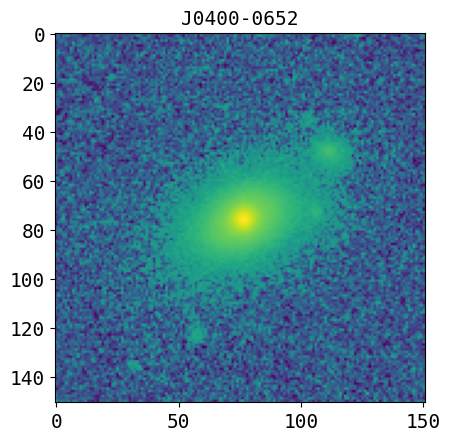

In [131]:
plt.imshow(imageAGN, norm='symlog')
plt.title(on)
# plt.plot(ys[0],xs[0],"ko",markersize=1)
# plt.plot(ys[1],xs[1],"ko",markersize=1)
#plt.imshow(mask_image(image=imageAGN,rad=15,intens=15,agn_mask_size=30), norm='symlog')
#imageAGN_masked = mask_image(image=imageAGN,rad=15,intens=15,agn_mask_size=30)

In [179]:
def _dofit_no_oversp(model, dataImage, psf, readnoise=0.22, expT=1, skylevel = 654.63, ncom=4, solver="NM",effgain=1):
    """do fit with not oversampled psf
       """
    fitter = pyimfit.Imfit(model,psf=psf)
    if float(ncom)==1.:
        fitter.loadData(dataImage,exp_time=expT, 
                    read_noise=readnoise, original_sky=skylevel,gain=effgain)
    else:
        fitter.loadData(dataImage,exp_time=expT, 
                    read_noise=readnoise, original_sky=skylevel,n_combined=ncom,gain=effgain)
    fitter.doFit(solver)
    fitConfig = fitter.getModelDescription()
    fitModelImage = fitter.getModelImage()
    fitResult = fitter.getFitResult()
    param_names = fitter.numberedParameterNames
    return fitConfig, fitModelImage, fitResult, param_names,fitter


Imax = imageAGN.max()
itot=1500
sersic_dict, psf_dict, gaussian_dict, flatsky_dict, flatbar_dict, exp_dict = makeModelDict(PA_ss=70, ell_ss=0.1, n_ss=1, I_ss=1, r_ss=20, Itot=itot,
                                                                     PA_lim=[0,360], ell_lim=[0.0,1.0], I_lim=[0.1,Imax],
                                                                     Iss_lim=[0.1,Imax], rss_lim=[0.1,framelim], Itot_lim=[0.1,1e4],
                                                                     sigma = 5, sigma_lim = [1,20], Isky = 2.5, Isky_lim =[0,10],
                                                                     h1=10,h2=10,h_lim=[0.1,framelim],alpha=0.1,alpha_lim=[0.1,framelim])
broken_exponentialParamsDict = {'PA': [0, 0,360], 'ell': [0.5, 0,1], 'I_0': [10.0, 0.0,Imax], 
                                'h1': [10, 0.1,framelim],'h2': [10, 0.1,framelim],'r_break': [10, 0.1,framelim],'alpha':[0.5,0,100]}
bexp_dict = {'name': "BrokenExponential", 'label': "bexp", 'parameters':broken_exponentialParamsDict}

GaussianRingAzParamsDict = {'PA': [40, 0,360], 'ell': [0.5, 0,1], 'A_maj':[100,0,framelim], 'A_min_rel':[0.5,0,1],
                          'R_ring':[10,0,100],'sigma_r':[5,0,100]}
gausR_dict = {'name': "GaussianRingAz", 'label': "GaussianRingAz", 'parameters': GaussianRingAzParamsDict}

exponentialParamDict = {'PA': [60, 0,100], 'ell': [0.1, 0,1], 'I_0': [20, 0.0,Imax], 'h': [10, 0,50]}
exp2_dict = {'name': "Exponential", 'label': "disk", 'parameters':exponentialParamDict}

flatbar = {'PA':[30,0,360], 'ell':[0.1,0,1],
            'deltaPA_max':[30,0,360], 'I_0':[1,0,Imax],
            'h1':[10,0.1,framelim], 'h2':[10,0.1,framelim,], 
            'r_break':[20,0,framelim], 'alpha':[0.1,0,framelim]}
flatbar0_dict = {'name': "FlatBar", 'label': "flat_bar", 'parameters':flatbar}


sersicParamsDict = {'PA': [60, 0, 360], 'ell_bulge': [0.1, 0, 1],
                    'n': [1, 0.0, 10],'I_e': [1, 0.0,Imax], 'r_e': [20, 0.0, framelim]}
sersic2_dict = {'name': "Sersic", 'label': "bulge 2", 'parameters': sersicParamsDict}

sersic1_dict = {'name': "Sersic", 'label': "bulge 1", 'parameters': sersicParamsDict}

sersic3ParamsDict = {'PA': [60, 0, 360], 'ell_bulge': [0.1, 0, 1],
                    'n': [4, 0.0, 10],'I_e': [10, 0.0,Imax], 'r_e': [15, 0.0, framelim]}
sersic3_dict = {'name': "Sersic", 'label': "bulge 3", 'parameters': sersic3ParamsDict}

ext_sersicParamsDict = {'PA': [130, 0, 360], 'ell_bulge': [0.3, 0, 1],
                    'n': [1, 0.0, 10],'I_e': [10, 0.0,Imax], 'r_e': [5, 0.0, framelim]}
sersic_ext_dict = {'name': "Sersic", 'label': "ext bulge", 'parameters': sersicParamsDict}


funcset_dict_sersic1= {'X0': [midF,0,framelim], 'Y0': [midF,0,framelim], 
                    'function_list': [sersic_dict,sersic2_dict,psf_dict]}
funcset_dict_sersic2= {'X0': [xs[0],0,framelim], 'Y0': [ys[0],0,framelim], 
                    'function_list': [sersic2_dict,psf_dict]}
funcset_dict_sersic3= {'X0': [xs[1],0,framelim], 'Y0': [ys[1],0,framelim], 
                    'function_list': [sersic2_dict]}



model_dict = {'function_sets': [funcset_dict_sersic1]}
model = pyimfit.ModelDescription.dict_to_ModelDescription(model_dict)

ModelObjectWrapper: about to call _model.CreateModelImage()...
ModelObjectWrapper: about to call _model.CreateModelImage()...
ModelObjectWrapper: about to call _model.CreateModelImage()...
X0_1: 75.16 
Y0_1: 77.19 
PA_1: 71.38 
ell_bulge_1: 0.42 
n_1: 2.30 
I_e_1: 55.62 
r_e_1: 9.78 
PA_2: 93.92 
ell_bulge_2: 0.53 
n_2: 0.05 
I_e_2: 55.44 
r_e_2: 4.02 
I_tot_3: 0.10 


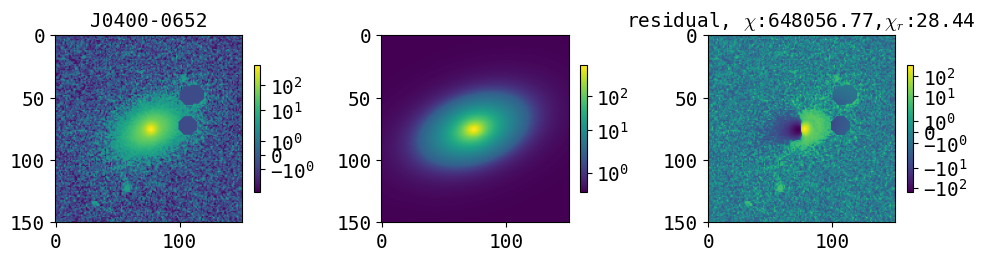

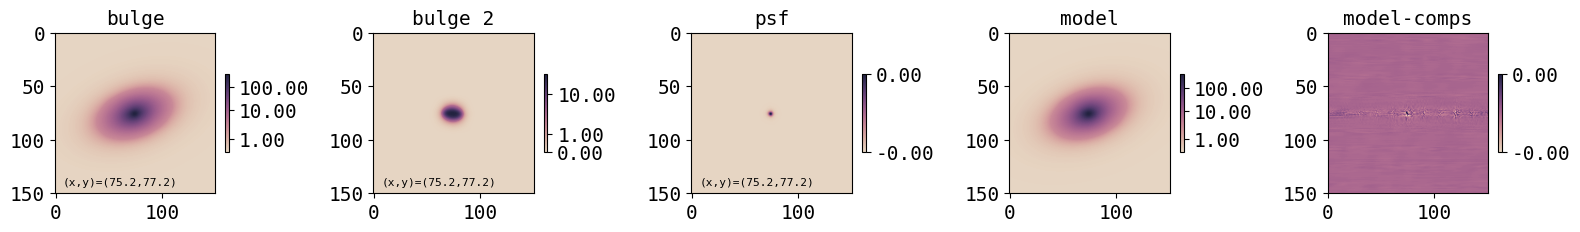

In [180]:
mosfile = glob.glob(os.path.expanduser("~/raw-data-agn/mos-fits-agn/*"+on+"*.mos.fits"))[0]
expfile = glob.glob(os.path.expanduser("~/raw-data-agn/exp-fits-agn/*"+on+"*.exp.fits"))[0]
with fits.open(os.path.expanduser(mosfile)) as hdul:
    hdu0 = hdul[0]

sky_level = hdu0.header['BACKGND'] #fits:[e-/s] native pixels, pf: value should be in the same units as the data pixels

with fits.open(os.path.expanduser(expfile)) as hdul:
    hdu = hdul[0]
exptime= hdu.header['EXPOSURE'] # fits: actual exp time, pf: total integration time
gain = hdu0.header['GAIN'] #fits: no unit specified, pf: in electrons/ADU
noise=hdu.header['EFFRN'] #fits:[e-], pf: in electrons
numcom=hdu.header['NCOADD'] #Number of Averaged Frames   
# Try for only 1 model
imageAGN_bs = imageAGN_masked-sky
image = imageAGN_bs
config0, modelIm0, fitRes0, pname0,fitter0  = _dofit_no_oversp(model,dataImage=image, psf=epsf,solver="LM",
                                                  readnoise=noise, expT=exptime, skylevel = sky_level, ncom=numcom,effgain=gain)
m = modelIm0
res = fitRes0.params
pname = pname0
fs = fitRes0.fitStat
fsr = fitRes0.fitStatReduced
comp_ims, comp_pos, comp_names = make_model_components(config0,imshape=image.shape[0])
comp_ims.append(m)
comp_names.append("model")
comp_pos.append([midF,midF])
[print(f"{pname0[i]}: {fitRes0.params[i]:.2f} ") for i in range(len(fitRes0.params))];
fig,ax = plt.subplots(1,3,figsize=(10,3))
#ax[0].imshow(imageAGN_bs-comp_ims[0],norm='symlog')
#ax[1].imshow(np.sum(comp_ims,axis=0)-comp_ims[0],norm='symlog')
im0 = ax[0].imshow(image,norm='symlog')
im1=ax[1].imshow(np.sum(comp_ims,axis=0),norm='symlog')
im2=ax[2].imshow(image-m, norm='symlog')
[fig.colorbar([im0,im1,im2][i],ax=ax[i],shrink=0.5) for i in range(3)]
ax[0].set_title(on)
ax[1].set_title("")
ax[2].set_title(f'residual, $\chi$:{fs:.2f},$\chi_r$:{fitRes0.fitStatReduced:.2f}')
fig.tight_layout();

plot_model_components(comp_ims,comp_names,comp_pos,isolist_comps,shrink_ratio=0.3)

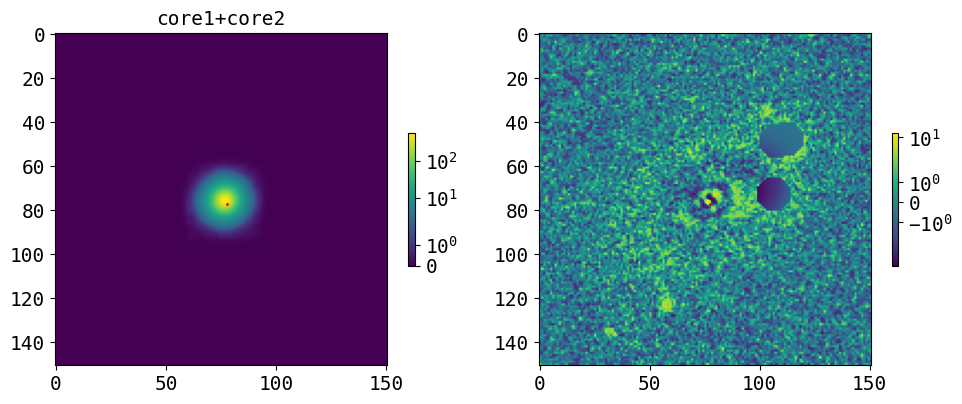

In [157]:
fig,ax = plt.subplots(1,2,figsize=(10,4))
im0=ax[0].imshow(comp_ims[1],norm='symlog')
im1=ax[1].imshow(image-m,norm='symlog')
ax[0].set_title('core1+core2')
[fig.colorbar([im0,im1][i],ax=ax[i],shrink=0.4) for i in range(2)]
fig.tight_layout();
ax[0].plot(comp_pos[0][0],comp_pos[0][1],"ro",markersize=1)
ax[1].plot(comp_pos[0][0],comp_pos[0][1],"ro",markersize=1)
# ax[1].plot(midF,midF,"ko",markersize=1)
#[print(f"{pname0[i]}: {fitRes0.params[i]:.2f} ") for i in range(len(fitRes0.params))];

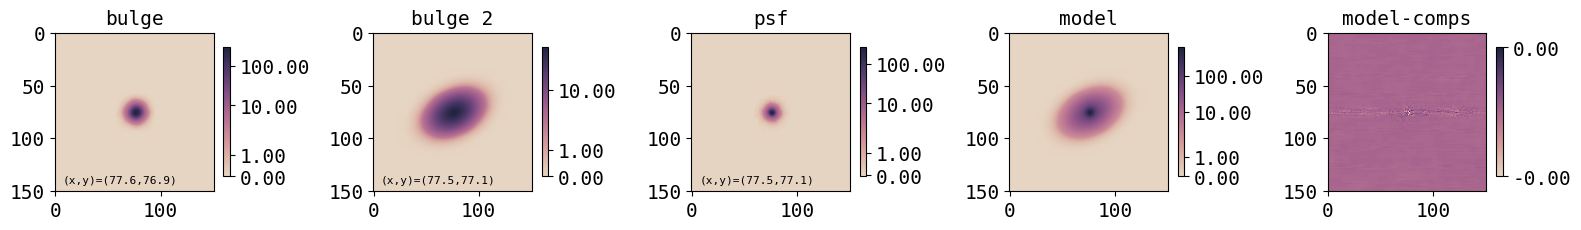

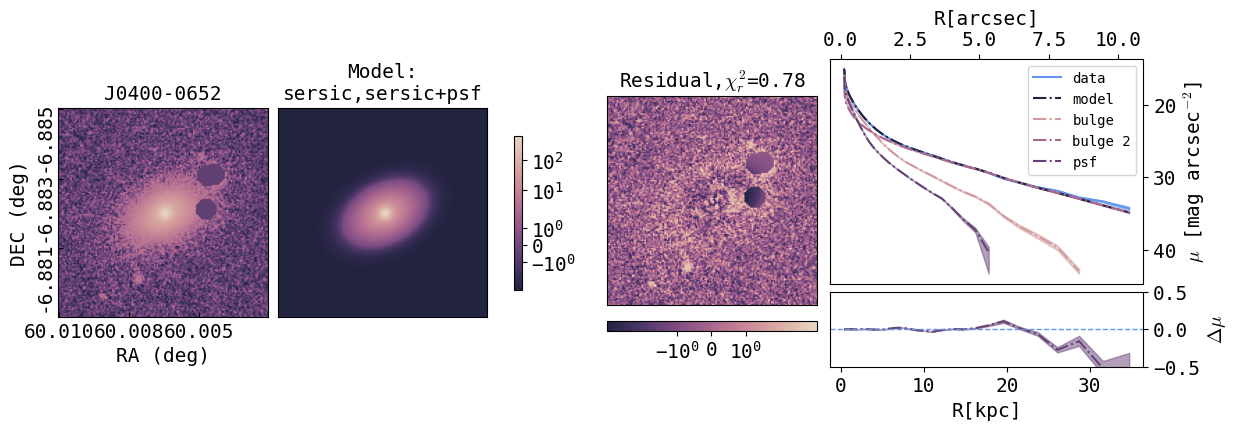

In [168]:
modelname = 'sersic,sersic+psf'
isolist_data = make_data_isophotes(image,10,midF)
isolist_comps = make_model_isophotes(isolist_data,comp_ims,comp_names,midF)  
plot_model_components(comp_ims,comp_names,comp_pos,isolist_comps)
sma_arcsec, sma_kpc, mu_data,mu_models,skycoords = radial_plot_params(imageFile, framelim,isolist_data,isolist_comps,hdu_exp=hdu0,z=0.2)
plot_everything(on,image,m,modelname,comp_names,fsr,sma_arcsec,sma_kpc,mu_data,mu_models,skycoords,colormap="ch:s=-.3,r=.6")

In [52]:
# comp_tot = [psf1,psf2,comp_ims[0]]
# comp_tot.append(np.sum(comp_tot,axis=0))
# comp_names = ['psf1','psf2','bulge','model']
# comp_pos=[psf1_pos,psf2_pos,comp_pos[0],[midF,midF]]

# plot_model_components(comp_tot,comp_names,comp_pos,isolist_comps,shrink_ratio=0.4)
# modelname = 'bar+ser+ser,\n ser,ext ser'
# isolist_comps = make_model_isophotes(isolist_data,comp_tot,comp_names,midF)  
# m = np.sum(comp_tot[:-1],axis=0)
# plot_everything_intens(on,imageAGN_bs,m,modelname,isolist_data,isolist_comps,comp_names,fs,fsr,sma25=False)

In [103]:
print(model)

X0		50.0		0.0,103.0
Y0		50.0		0.0,103.0
FUNCTION Sersic   # LABEL bulge 2
PA		90.0		0.0,360.0
ell_bulge		0.5		0.0,1.0
n		1.0		0.0,10.0
I_e		100.0		0.0,126.8216552734375
r_e		3.0		0.0,103.0

FUNCTION Sersic   # LABEL bulge
PA		70.0		0.0,360.0
ell_bulge		0.1		0.0,1.0
n		1.0		0.0,10.0
I_e		1.0		0.1,126.8216552734375
r_e		20.0		0.1,103.0



# plot fit files

In [23]:
on = "J0820+1801"
with open(os.path.expanduser('/home/insepien/agn-result/fit/final_fit/J0820+1801.pkl'), 'rb') as file:
    d = pickle.load(file)
    
with open (os.path.expanduser("/home/insepien/agn-result/psf_pkls/psf_"+on+".pkl"), "rb") as f:
    p = pickle.load(f)
epsf = p['psf'].data
image = d['imageSS']
print(d.keys())
#n = 1
#[print(f"{paramnames[n][i]}: {params[n][i]}") for i in range(len(paramnames[n]))];

dict_keys(['imageSS', 'modelNames', 'configs', 'modelImage', 'fitResults', 'paramNames'])


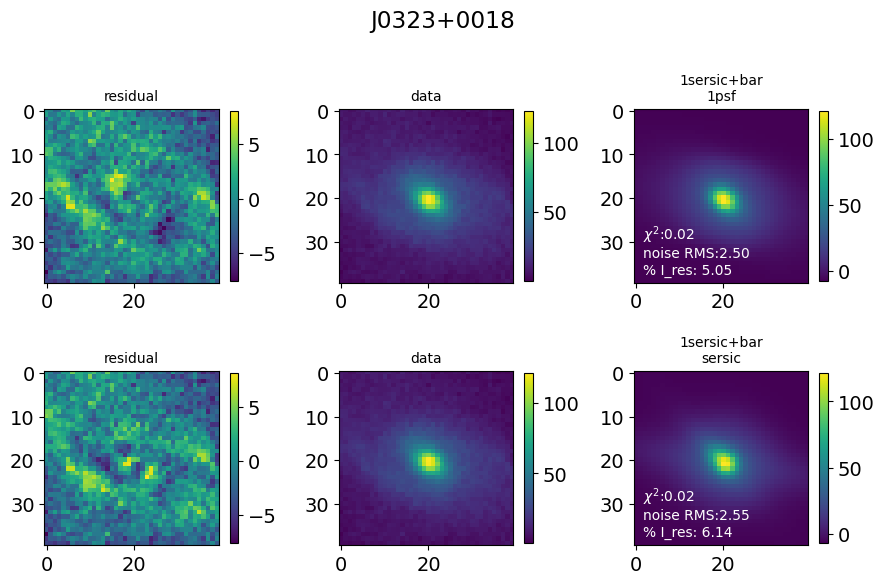

In [10]:
plot2best=True
image = d['imageSS']
modelNum = len(d['fitResults'])
fitStats = [d['fitResults'][i].fitStatReduced for i in range(modelNum)]
best_2ind = np.argsort([d['fitResults'][i].fitStatReduced for i in range(modelNum)])[:2]
if plot2best:
    nrows = 2
    ff = [best_2ind, np.arange(2)] 
else:
    nrows = modelNum
    ff = [np.argsort(fitStats),np.arange(nrows)]   
ncols=3 
fig,ax = plt.subplots(nrows,ncols,figsize=(ncols*3,nrows*3))  
for i, j in zip(ff[0],ff[1]):
    resi = image-d['modelImage'][i]
    im0 = ax[j,0].imshow(resi)
    im1 = ax[j,2].imshow(d['modelImage'][i])
    im2 = ax[j,1].imshow(image)
    [fig.colorbar([im0,im1,im2][k], ax=ax[j,k], shrink=0.7) for k in range(ncols)]
    rmsNoise = np.sqrt(np.sum(resi**2)/image.shape[0]**2)
    iRatio = np.sum(resi)/np.sum(image)*100
    ax[j,2].text(0.05, 0.25, f"$\chi^2$:{fitStats[i]:.2f}", transform=ax[j,2].transAxes, fontsize=10, color='w')
    ax[j,2].text(0.05, 0.15, f"noise RMS:{rmsNoise:.2f}", transform=ax[j,2].transAxes, fontsize=10, color='w')
    ax[j,2].text(0.05, 0.05, f"% I_res: {np.abs(iRatio):.2f}", transform=ax[j,2].transAxes, fontsize=10, color='w')
    title = list(d['modelNames'].keys())[i]
    title = '\n'.join(title.split(',', 1)) if len(title) > 15 else title
    ax[j,2].set_title(title, fontsize=10)
    ax[j,0].set_title("residual", fontsize=10)
    ax[j,1].set_title("data", fontsize=10)
fig.suptitle(on,y=0.99)
fig.tight_layout(pad=0.9, h_pad=0, w_pad=1)